# Simple classification with pytorch

## Data processing

### Create a csv file 

In [1]:
import os
import glob
import yaml
import pandas as pd

def make_csv_path(excluded_labels=None):
    list_images = glob.glob('../data/raw/**/*.jpg', recursive=True)
    df = pd.DataFrame({'path': list_images})
    df['label'] = df['path'].apply(lambda x:os.path.basename(os.path.dirname(x)))
    if excluded_labels is not None:
        df = df[~df['label'].isin(excluded_labels)]
        print('Csv file constituted with {nrows} images, representing {nclasses} classes, excluding {exclusion}'.format(
        nrows=df.shape[0],
        nclasses=len(df['label'].unique()),
        exclusion= ','.join(excluded_labels)
        ))
    else:
        print('Csv file constituted with {nrows} images, representing the {nclasses} classes'.format(
            nrows=df.shape[0],
            nclasses=len(df['label'].unique())
        ))
    
    # Converting classes to number 
    labels = df['label'].unique()
    labels.sort()
    labels_map = {label:i for i, label in enumerate(labels)}
    df['y'] = df['label'].map(labels_map)

    labels_map_save = {i:label for i, label in enumerate(labels)}
    # Saving the map numbers -> label
    with open("../data/processed/labels_map.yaml", "w") as outfile:
        yaml.dump(labels_map_save, outfile)

    df.to_csv('../data/interim/filepath.csv', index=False)

make_csv_path(excluded_labels=['Corals', 'Crabs'])

Csv file constituted with 10701 images, representing 17 classes, excluding Corals,Crabs


### Creating a Custom Dataset class for the files 

In [2]:
# Modules

import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        filepath_df = pd.read_csv(annotations_file)
        self.img_labels = filepath_df['y']
        self.img_dir = filepath_df['path']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

image_size = (227,227)

transformf = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor()
])

dataset = CustomImageDataset(annotations_file='../data/interim/filepath.csv', transform=transformf)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)



/home/aurelien/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_mean_and_std(loader):
    mean = 0. 
    std = 0. 
    total_images_count = 0

    for images,_ in loader:
        image_count_batch = images.size(0)
        images = images.view(image_count_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_batch
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std
mean, std = get_mean_and_std(dataloader)

dict_mean_std = {'mean': mean.tolist(),
'std': std.tolist()}

print(dict_mean_std)

with open("../data/processed/image_mean_std.yaml", "w") as outfile:
    yaml.dump(dict_mean_std, outfile)

{'mean': [0.305789053440094, 0.4046460688114166, 0.42739832401275635], 'std': [0.1787707507610321, 0.1817948818206787, 0.180245041847229]}


### Plot some images for verification

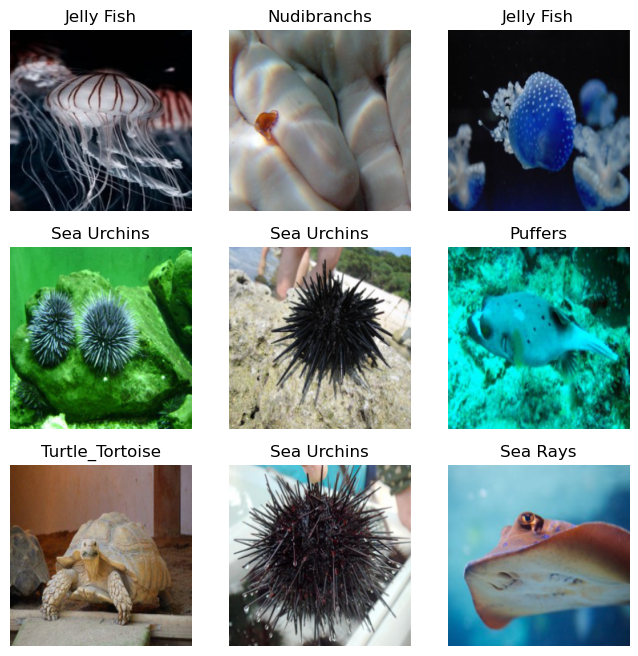

In [4]:
# Modules
import torch
import matplotlib.pyplot as plt 

# Scripts
label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, y = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split the dataset + data augmentation

+ Track the files with dvc 
+ Data augmentation parameters for training data, test data ? 

In [5]:
# Modules
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Script

def split_dataset(annotations_file, output_folder, test_split=0.2, val_split=0.2, random_seed=99):
    dataset = pd.read_csv(annotations_file)
    train, test = train_test_split(dataset, stratify=dataset['label'], test_size=test_split, random_state=random_seed)
    train, val = train_test_split(train, stratify=train['label'], test_size=val_split, random_state=random_seed)
    train.to_csv(os.path.join(output_folder, 'train.csv'), index=False)
    train.to_csv(os.path.join(output_folder, 'val.csv'), index=False)
    test.to_csv(os.path.join(output_folder, 'test.csv'), index=False)


split_dataset(annotations_file='../data/interim/filepath.csv', output_folder='../data/processed', val_split=0.2, random_seed=99)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


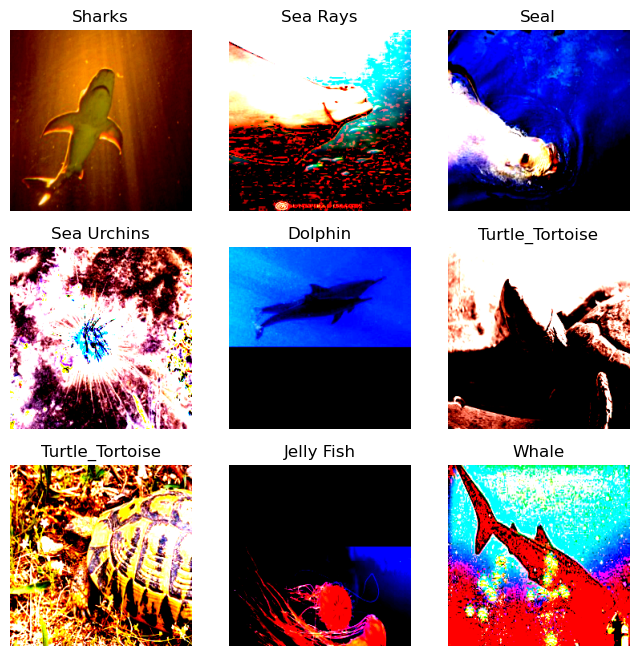

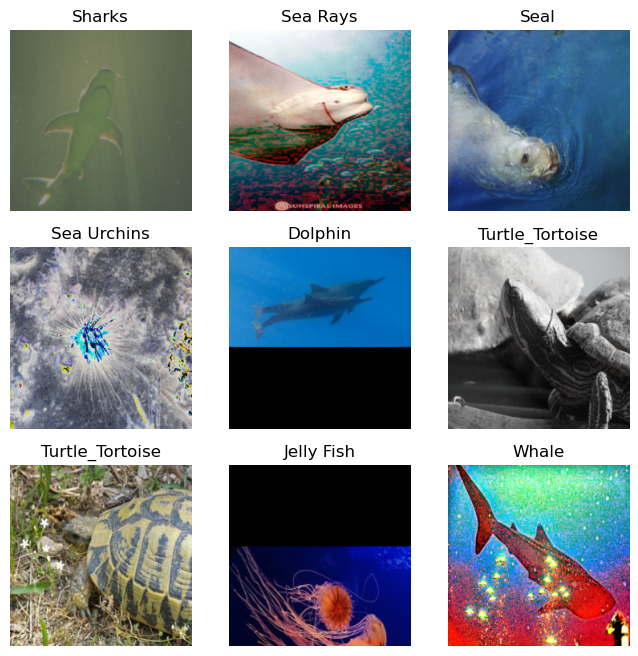

In [6]:
# Modules
import yaml
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Dependencies
mean_std = yaml.safe_load(open('../data/processed/image_mean_std.yaml'))

# Parameters
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
image_size = (227,227)

# Scripts 
train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_T=T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))

denorm = T.Normalize(
    mean=[-m / s for m, s in zip(mean_std['mean'], mean_std['std'])],
    std=[1.0 / s for s in mean_std['std']])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(denorm(img).permute(1, 2, 0))
plt.show()


## Training the network

To do list for tomorrow: 
- Transform the pytorch workflow to pytorch-lightning modules in order to enable the autologging of parameters
    + https://www.mlflow.org/docs/latest/python_api/mlflow.pytorch.html#
    + https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction.html
    + https://pytorch-lightning.readthedocs.io/en/stable/notebooks/course_UvA-DL/11-vision-transformer.html
- Run the pytorch-lightning pipeline and check mlflow UI 
- Define hyperparameters to tune


In [7]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
import torch
from torch import nn
import torchvision
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

num_classes = len(label_map)
num_epochs = 5
batch_size = 16
learning_rate = 0.01
image_size = (227,227)
feature_extract=True


model = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1', pretrained=True, progress=True)
set_parameter_requires_grad(model, feature_extract)
num_ftrs = model.classifier[-1].in_features
model.classifier[3] = nn.Linear(num_ftrs, num_classes)

Using device: cpu



/home/aurelien/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
import mlflow.pytorch
from mlflow import MlflowClient
import pytorch_lightning as pl

mlflow.set_tracking_uri("../mlruns")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))


train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    ])

train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(params_to_update, lr=learning_rate, weight_decay = 0.005, momentum=0.9)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=20)

dataloaders_dict = {'train':train_dataloader, 'val':val_dataloader}

with mlflow.start_run() as run:
    trainer.fit(mnist_model, train_loader)

with mlflow.start_run():
    # Auto log all MLflow entities
    mlflow.pytorch.autolog()

    # Train and evaluate
    model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)



Current tracking uri: ../mlruns
Params to learn:
	 classifier.3.weight
	 classifier.3.bias
Epoch 0/4
----------
train Loss: 1.2882 Acc: 0.6032
val Loss: 0.7404 Acc: 0.7747

Epoch 1/4
----------
train Loss: 1.0871 Acc: 0.6589
val Loss: 0.6650 Acc: 0.7966

Epoch 2/4
----------
train Loss: 1.0655 Acc: 0.6631
val Loss: 0.6331 Acc: 0.8070

Epoch 3/4
----------
train Loss: 1.0251 Acc: 0.6730
val Loss: 0.6001 Acc: 0.8249

Epoch 4/4
----------
train Loss: 1.0254 Acc: 0.6673
val Loss: 0.5938 Acc: 0.8159

Training complete in 7m 41s
Best val Acc: 0.824912


## Predict and evaluate on test set

In [11]:
from sklearn.metrics import classification_report


test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
 

#print(classification_report(y_true, y_pred, digits=4))

In [23]:
print(classification_report(y_true, y_pred, digits=4, target_names=label_map.values()))

                 precision    recall  f1-score   support

        Dolphin     0.6747    0.7226    0.6978       155
            Eel     0.5918    0.5859    0.5888        99
     Jelly Fish     0.8681    0.9240    0.8952       171
        Lobster     0.7333    0.6600    0.6947       100
    Nudibranchs     0.7358    0.7800    0.7573       100
        Octopus     0.5606    0.6607    0.6066       112
        Penguin     0.6981    0.7708    0.7327        96
        Puffers     0.7071    0.6604    0.6829       106
       Sea Rays     0.7465    0.5146    0.6092       103
    Sea Urchins     0.9492    0.9655    0.9573       116
       Seahorse     0.8261    0.6000    0.6951        95
           Seal     0.6771    0.7927    0.7303        82
         Sharks     0.5484    0.5763    0.5620       118
          Squid     0.7391    0.5312    0.6182        96
       Starfish     0.9417    0.9798    0.9604        99
Turtle_Tortoise     0.8582    0.9103    0.8835       379
          Whale     0.6273    